In [1]:
import numpy as np
import cv2

from functional import (
    plot_gray_images,
    plot_location,
    plot_camera_view_area,
    plot_camera_view_with_defense_point,
    get_label_mask,
    Label,
    get_primitive_rectangles,
    draw_primitive_rectangles,
    load_masks,
    get_primitive_mask_by_rectangles,
    get_neighbor_pixels_of_label,
    PossibleLocations,
    remove_outer_locations,
    get_viewed_points_from_point,
    Point,
    find_best_location,
    generate_random_defense_point,
    save_camera_view_with_defense_point
)

%reload_ext autoreload
%autoreload 2

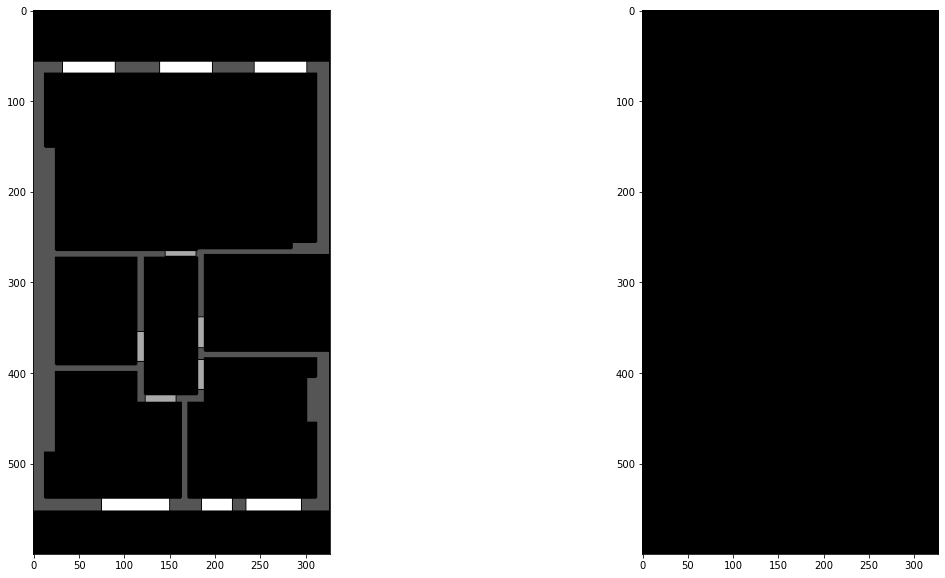

In [22]:
masks = load_masks('masks')
some_mask = masks[6]
plot_gray_images(some_mask)
# plot_gray_images(*masks)

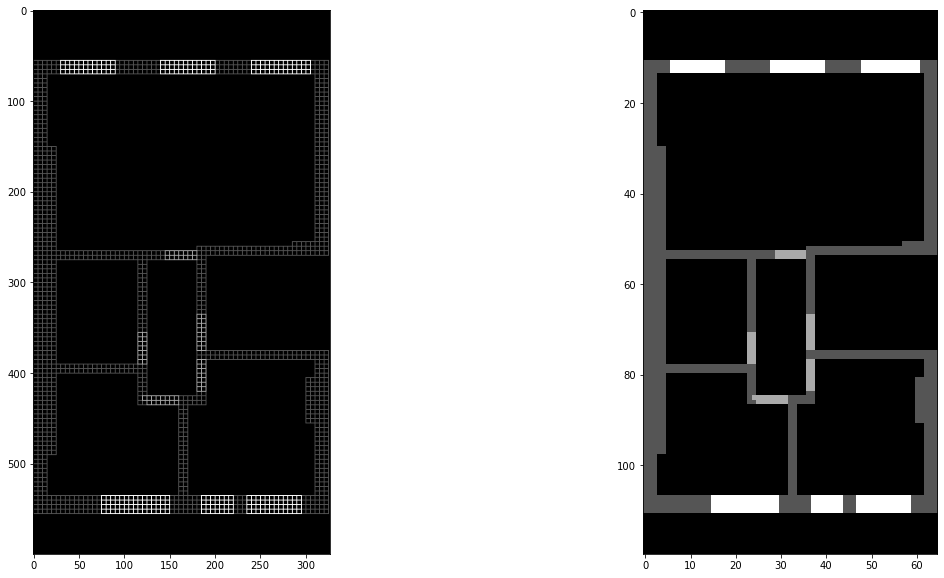

In [23]:
rectangles_mask = np.zeros_like(some_mask)
rectangles = dict()
for label in Label:
    label_mask = get_label_mask(some_mask, label)
    label_rectangles = get_primitive_rectangles(label_mask)
    rectangles[label] = label_rectangles
    draw_primitive_rectangles(rectangles_mask, label_rectangles, color=label.value)

primitive_mask = get_primitive_mask_by_rectangles(some_mask, rectangles)
plot_gray_images(rectangles_mask, primitive_mask)

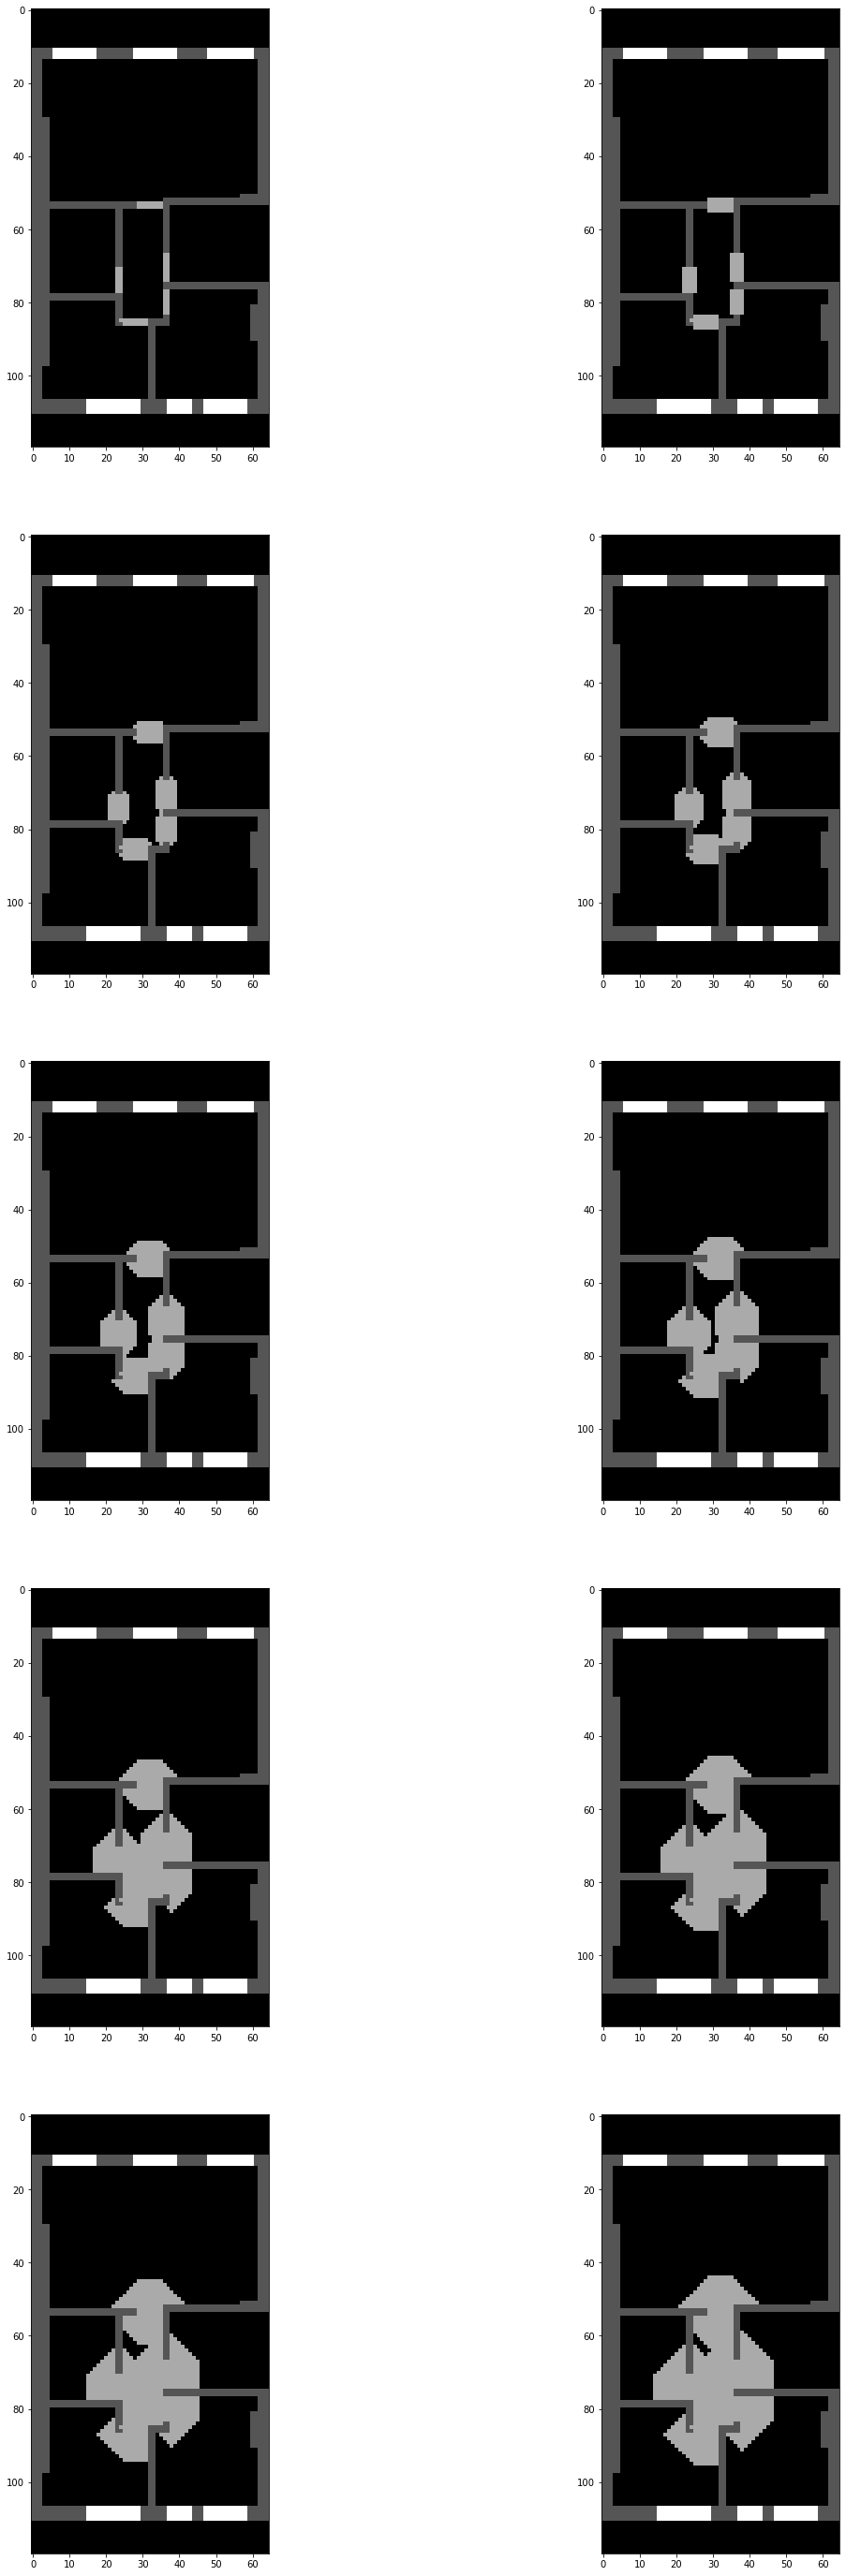

In [24]:
iter_num = 10

primitive_masks = np.ndarray(shape=(iter_num, *primitive_mask.shape), dtype=np.uint8)
primitive_masks[0] = primitive_mask.copy()

for idx in range(1, iter_num):
    previous_primitive_mask = primitive_masks[idx - 1].copy()
    neighbors = get_neighbor_pixels_of_label(previous_primitive_mask, Label.door)
    previous_primitive_mask[neighbors] = Label.door.value
    primitive_masks[idx] = previous_primitive_mask

plot_gray_images(*primitive_masks)

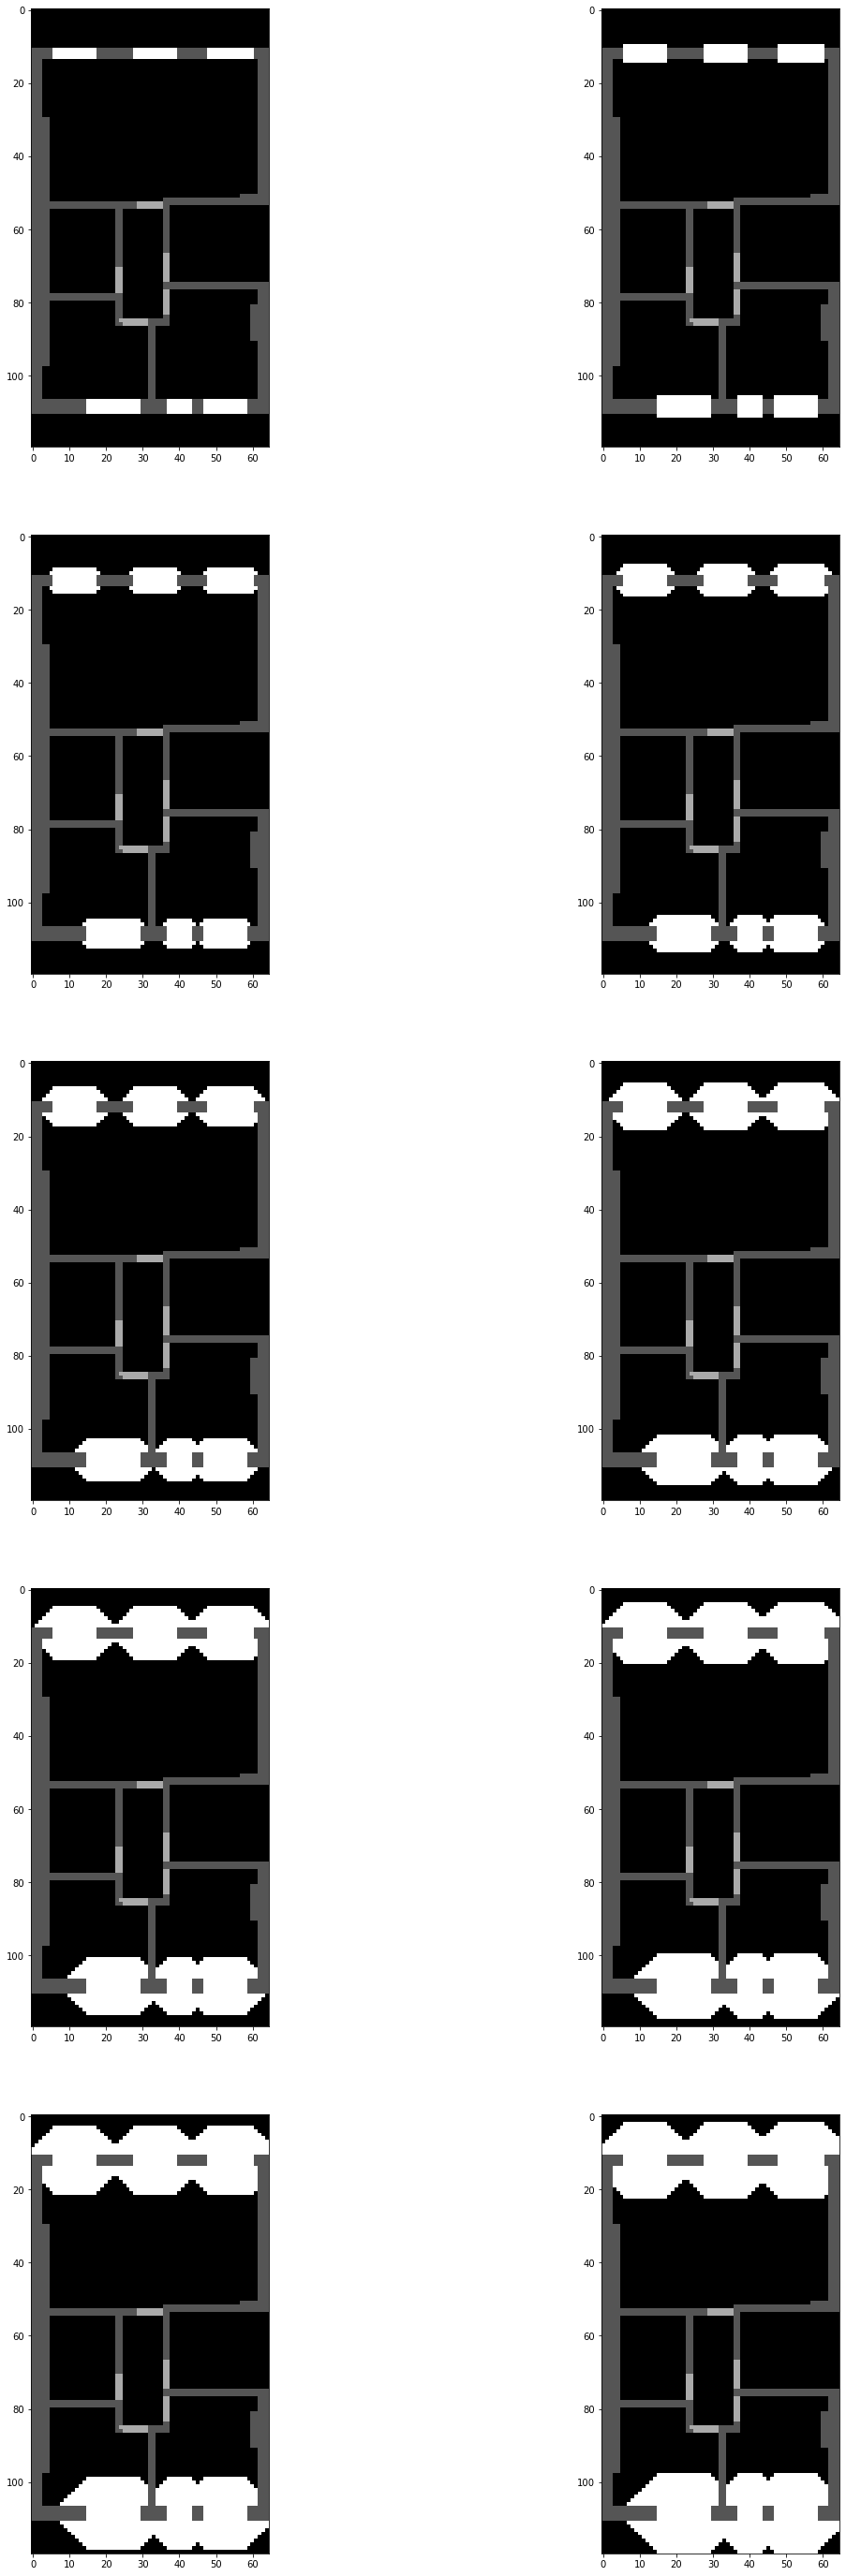

In [25]:
iter_num = 10

primitive_masks = np.ndarray(shape=(iter_num, *primitive_mask.shape), dtype=np.uint8)
primitive_masks[0] = primitive_mask.copy()

for idx in range(1, iter_num):
    previous_primitive_mask = primitive_masks[idx - 1].copy()
    neighbors = get_neighbor_pixels_of_label(previous_primitive_mask, Label.window)
    previous_primitive_mask[neighbors] = Label.window.value
    primitive_masks[idx] = previous_primitive_mask

plot_gray_images(*primitive_masks)

In [26]:
locations = PossibleLocations(get_neighbor_pixels_of_label(primitive_mask, Label.wall))
remove_outer_locations(locations, primitive_mask)

door_rating_mask = primitive_mask.copy()
for _ in range(10):
    neighbors = get_neighbor_pixels_of_label(door_rating_mask, Label.door)
    door_rating_mask[neighbors] = Label.door.value

locations.adjust_rating(where=(door_rating_mask == Label.door.value).nonzero(), rating_delta=-10)

window_rating_mask = primitive_mask.copy()
for _ in range(10):
    neighbors = get_neighbor_pixels_of_label(window_rating_mask, Label.window)
    window_rating_mask[neighbors] = Label.window.value

locations.adjust_rating(where=(window_rating_mask == Label.window.value).nonzero(), rating_delta=10)

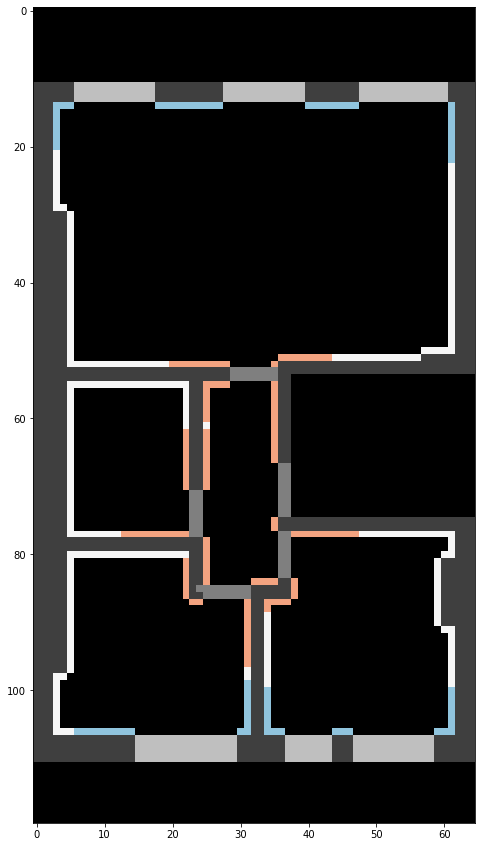

In [27]:
# locations = PossibleLocations(get_neighbor_pixels_of_label(primitive_mask, Label.wall))
# remove_outer_locations(locations, primitive_mask)
plot_location(primitive_mask, locations)

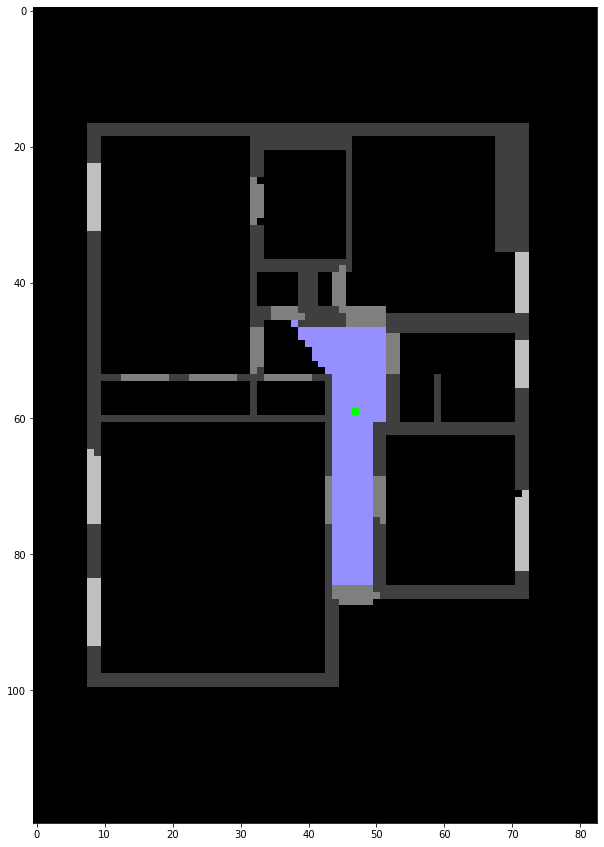

In [24]:
mask_with_viewed_area = primitive_mask.copy()
point = Point(47, 59)
*viewed_area_points, _ = get_viewed_points_from_point(mask_with_viewed_area, point)
plot_camera_view_area(mask_with_viewed_area, point)

100%|██████████| 565/565 [00:02<00:00, 189.32it/s]


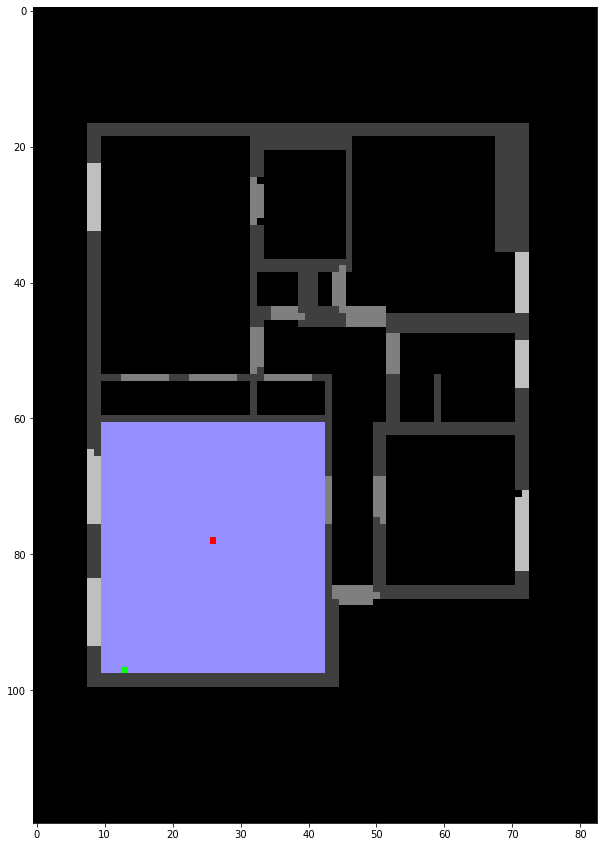

In [33]:
# defense_point = Point(60, 50)
defense_point = generate_random_defense_point(primitive_mask)
best_location = find_best_location(primitive_mask, locations, defense_point)
plot_camera_view_with_defense_point(
    primitive_mask,
    camera_location=best_location,
    defense_point=defense_point
)

In [4]:
for idx, mask in enumerate(masks[:5]):
    # Get primitive mask
    rectangles_mask = np.zeros_like(mask)
    rectangles = dict()
    for label in Label:
        label_mask = get_label_mask(mask, label)
        label_rectangles = get_primitive_rectangles(label_mask)
        rectangles[label] = label_rectangles
        draw_primitive_rectangles(rectangles_mask, label_rectangles, color=label.value)
    primitive_mask = get_primitive_mask_by_rectangles(mask, rectangles)

    # Get possible locations
    locations = PossibleLocations(get_neighbor_pixels_of_label(primitive_mask, Label.wall))
    remove_outer_locations(locations, primitive_mask)

    door_rating_mask = primitive_mask.copy()
    for _ in range(10):
        neighbors = get_neighbor_pixels_of_label(door_rating_mask, Label.door)
        door_rating_mask[neighbors] = Label.door.value

    locations.adjust_rating(where=(door_rating_mask == Label.door.value).nonzero(), rating_delta=-10)

    window_rating_mask = primitive_mask.copy()
    for _ in range(10):
        neighbors = get_neighbor_pixels_of_label(window_rating_mask, Label.window)
        window_rating_mask[neighbors] = Label.window.value

    locations.adjust_rating(where=(window_rating_mask == Label.window.value).nonzero(), rating_delta=10)

    # Find best location
    for defense_point_idx in range(3):
        defense_point = generate_random_defense_point(primitive_mask)
        best_location = find_best_location(primitive_mask, locations, defense_point)
        save_camera_view_with_defense_point(
            primitive_mask,
            camera_location=best_location,
            defense_point=defense_point,
            filename=f'mask_{idx}_example_{defense_point_idx}.png'
        )

100%|██████████| 450/450 [00:01<00:00, 228.59it/s]
